##  **🧬 Projeto de BI**: Painel de Indicadores de Testes Moleculares e não automatizado

Fase de Modelagem

Datasets e diciononário de dados extraídos do repositório Kaggle: https://www.kaggle.com/datasets/marciosaraiva/covid19-data-sharing-br-einstein-hospital



In [1]:
#Imports necessários para o projeto

import pandas as pd
import numpy as np
from faker import Faker
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


## Análise Exploratória 

In [2]:
# Dataset com as informações dos exames
df1= pd.read_csv("einstein_small_dataset_exames.csv", sep='|')

In [3]:
# Dataset com as informações dos pacientes
df2= pd.read_csv("einstein_small_dataset_paciente1.csv", sep='|')

In [4]:
df1.head()

,id_paciente,dt_coleta,de_origem,de_exame,de_analito,de_resultado,cd_unidade,de_valor_referencia
0,202018,13/06/2020,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado
1,202025,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgG, COVID19",0.07,AU/ml,<=0.90
2,202025,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,COVID IgG Interp,Não reagente,NaN,NaN
3,202025,11/05/2020,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado
4,202025,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgM, COVID19",0.33,AU/ml,<=0.90


In [5]:
df2.head()

,id_paciente,ic_sexo,aa_nascimento,cd_pais,cd_uf,cd_municipio,cd_distrito
0,204591,M,1954,BR,SP,SAO PAULO,NaN
1,204990,F,1954,BR,SP,SAO PAULO,NaN
2,204653,F,1956,BR,SP,SAO PAULO,NaN
3,202577,F,1957,BR,SP,SAO PAULO,NaN
4,206125,M,1957,BR,SP,SAO PAULO,NaN


In [6]:
df1.isnull().sum()

id_paciente              0
dt_coleta                0
de_origem                0
de_exame                 0
de_analito               0
de_resultado             0
cd_unidade             566
de_valor_referencia    422
dtype: int64


## Geração de colunas complementares para cálculo de KPIs


In [7]:

# Inicializa gerador de dados falsos
fake = Faker('pt_BR')

# Número de registros existentes
n = len(df1)

# 1. Colunas de identificação

df1['id_exame'] = [f'EX{i:05d}' for i in range(1, n+1)]
df1['tipo_exame'] = np.random.choice(['PCR', 'RT-qPCR', 'NGS', 'ELISA'], n)


# 2. Colunas operacionais

df1['equipamento'] = np.random.choice(['QuantStudio 5', 'CFX96', 'MiSeq', 'GeneAmp 9700'], n)
df1['operador'] = np.random.choice(['João Silva', 'Maria Santos', 'Ana Souza', 'Pedro Lima', 'Lucas Costa'], n)


# 3. Colunas temporais

# Data e hora de início aleatória nos últimos 30 dias
df1['data_inicio'] = [fake.date_time_between(start_date='-30d', end_date='now') for _ in range(n)]

# Tempo de execução entre 30 e 180 minutos
duracao = np.random.randint(30, 180, n)
df1['data_fim'] = df1['data_inicio'] + pd.to_timedelta(duracao, unit='m')


# 4. Colunas de status e qualidade

df1['status'] = np.random.choice(['Concluído', 'Falha Técnica', 'Repetido'], n, p=[0.85, 0.1, 0.05])
df1['repeticao'] = (df1['status'] == 'Repetido').astype(int)


# 5. Colunas de custo

# Custos simulados em reais
df1['custo_material'] = np.random.uniform(100, 400, n).round(2)
df1['custo_mao_obra'] = np.random.uniform(50, 150, n).round(2)


# 6. Relação com paciente

df1['id_paciente'] = [f'P{np.random.randint(1, 301):04d}' for _ in range(n)]


# 7. Exporta o novo dataset

df1.to_csv('einstein_small_dataset_exames_completo.csv', index=False)

print("✅ Dataset atualizado com sucesso!")
print("Novas colunas adicionadas:", 
      ['id_exame','tipo_exame','equipamento','operador','data_inicio','data_fim',
       'status','repeticao','custo_material','custo_mao_obra','id_paciente'])


✅ Dataset atualizado com sucesso!
Novas colunas adicionadas: ['id_exame', 'tipo_exame', 'equipamento', 'operador', 'data_inicio', 'data_fim', 'status', 'repeticao', 'custo_material', 'custo_mao_obra', 'id_paciente']


### Análise do Dataset final

In [8]:
# Dataset final que será usado no PowerBI
df3= pd.read_csv('einstein_small_dataset_exames_completo.csv')

In [9]:
df3.head()

,id_paciente,dt_coleta,de_origem,de_exame,de_analito,de_resultado,cd_unidade,de_valor_referencia,id_exame,tipo_exame,equipamento,operador,data_inicio,data_fim,status,repeticao,custo_material,custo_mao_obra
0,P0194,13/06/2020,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado,EX00001,RT-qPCR,QuantStudio 5,João Silva,2025-09-30 06:56:56,2025-09-30 08:10:56,Concluído,0,310.64,142.46
1,P0067,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgG, COVID19",0.07,AU/ml,<=0.90,EX00002,NGS,CFX96,Ana Souza,2025-09-30 10:25:57,2025-09-30 11:37:57,Concluído,0,396.33,76.74
2,P0254,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,COVID IgG Interp,Não reagente,NaN,NaN,EX00003,RT-qPCR,MiSeq,Pedro Lima,2025-10-04 08:42:58,2025-10-04 09:28:58,Concluído,0,248.77,149.17
3,P0297,11/05/2020,HOSP,PCR em tempo real para detecção de Coron,Resultado COVID-19:,Não detectado,NaN,Não detectado,EX00004,RT-qPCR,QuantStudio 5,Ana Souza,2025-10-06 00:03:29,2025-10-06 02:43:29,Falha Técnica,0,342.70,103.49
4,P0162,11/05/2020,HOSP,Sorologia SARS-CoV-2/COVID19 IgG/IgM,"IgM, COVID19",0.33,AU/ml,<=0.90,EX00005,RT-qPCR,GeneAmp 9700,Maria Santos,2025-10-12 12:32:36,2025-10-12 14:25:36,Concluído,0,130.45,145.97


In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_paciente          2067 non-null   object 
 1   dt_coleta            2067 non-null   object 
 2   de_origem            2067 non-null   object 
 3   de_exame             2067 non-null   object 
 4   de_analito           2067 non-null   object 
 5   de_resultado         2067 non-null   object 
 6   cd_unidade           1501 non-null   object 
 7   de_valor_referencia  1645 non-null   object 
 8   id_exame             2067 non-null   object 
 9   tipo_exame           2067 non-null   object 
 10  equipamento          2067 non-null   object 
 11  operador             2067 non-null   object 
 12  data_inicio          2067 non-null   object 
 13  data_fim             2067 non-null   object 
 14  status               2067 non-null   object 
 15  repeticao            2067 non-null   i

In [11]:
df3.isnull().sum()

id_paciente              0
dt_coleta                0
de_origem                0
de_exame                 0
de_analito               0
de_resultado             0
cd_unidade             566
de_valor_referencia    422
id_exame                 0
tipo_exame               0
equipamento              0
operador                 0
data_inicio              0
data_fim                 0
status                   0
repeticao                0
custo_material           0
custo_mao_obra           0
dtype: int64

#### Foi verificado, nas análises acima, que não há dados faltantes nas colunas importantes do dataset principal, dessa forma podemos seguir com as próximas análises.
No Power BI será feita um relacionamento entre as bases, usando como vínculo o id do cliente -contido em ambas as bases.


## 🔍Pré-análise exploratória

Uma visão prévia dos KPI's antes de migrá-los para o Power BI.


📊 INDICADORES GERAIS (Pré-análise BI)
1. Taxa de falhas técnicas: 9.24%
2. Tempo médio de liberação: 106.0 min
3. Custo médio por exame: R$ 349.75
4. Taxa de repetição: 4.89%
5. Total de exames: 2067
6. Operadores: 5
7. Tipos de exame: 4


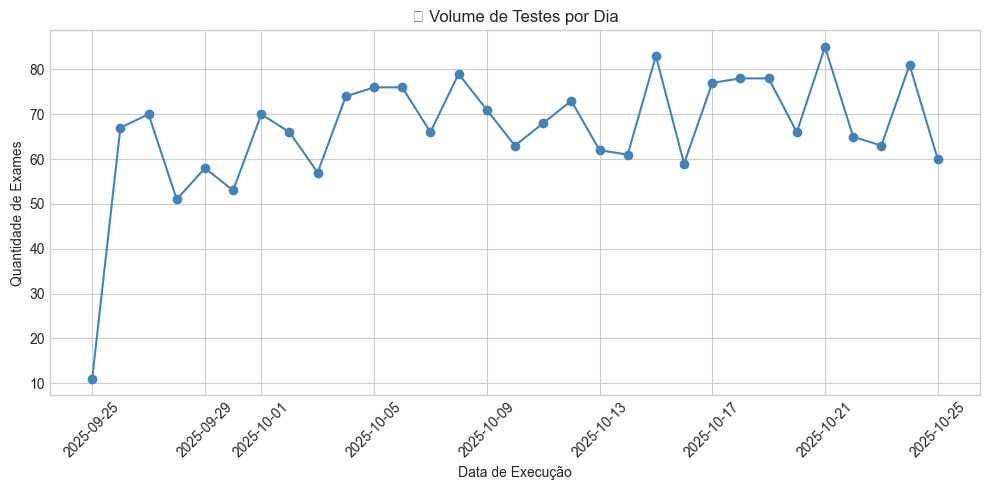

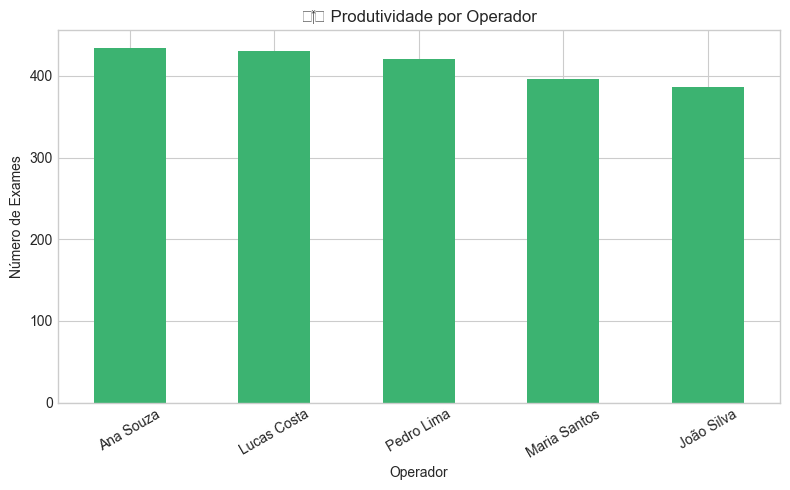

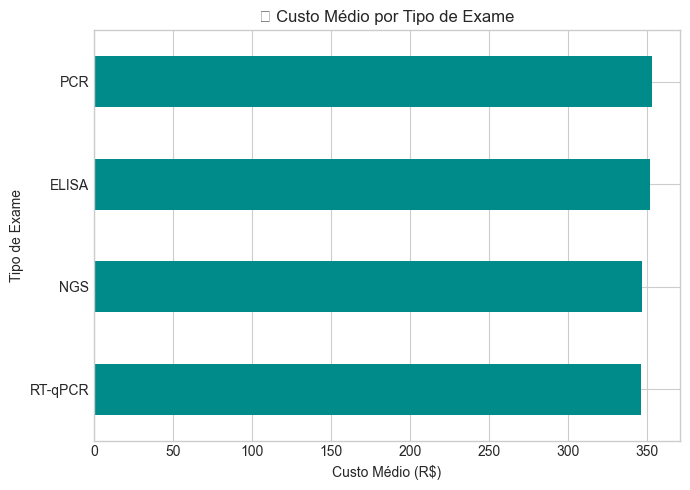

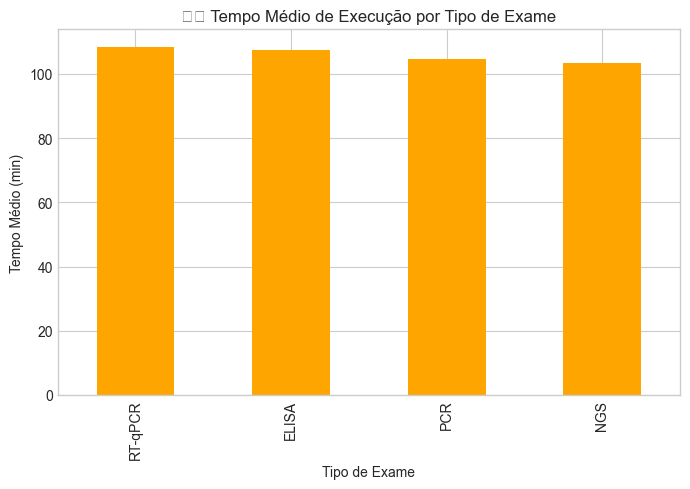

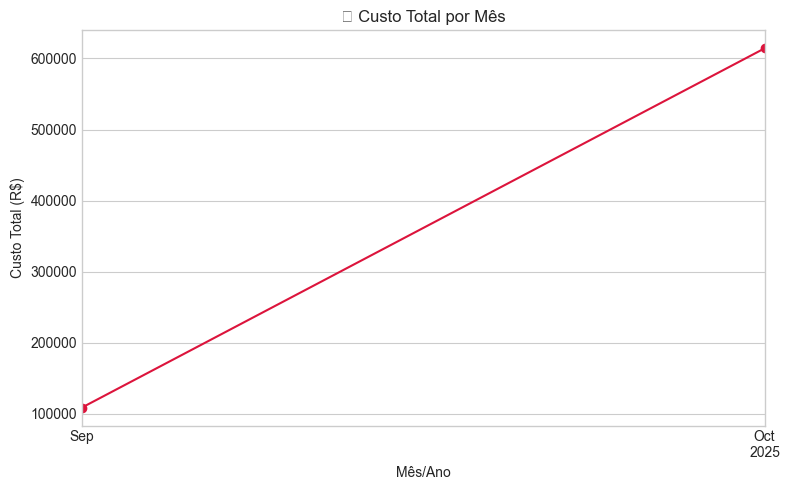

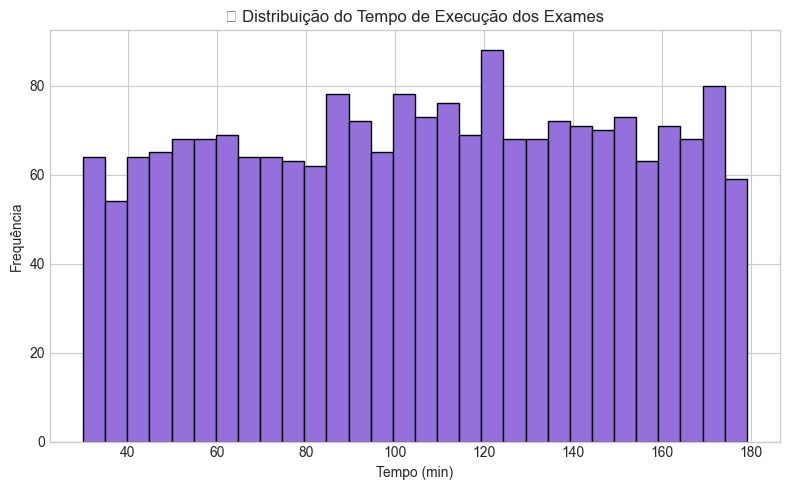

In [12]:

# Garantir que datas estejam em formato datetime
df3['data_inicio'] = pd.to_datetime(df3['data_inicio'])
df3['data_fim'] = pd.to_datetime(df3['data_fim'])

# 1️⃣ KPIs principais
tempo_execucao_min = (df3['data_fim'] - df3['data_inicio']).dt.total_seconds() / 60
custo_total = df3['custo_material'] + df3['custo_mao_obra']

# Taxa de falhas técnicas (%)
taxa_falhas = (df3[df3['status'] == 'Falha Técnica'].shape[0] / df3.shape[0]) * 100

# Tempo médio de liberação (min)
tempo_medio = tempo_execucao_min.mean()

# Custo médio por exame (R$)
custo_medio = custo_total.mean()

# Taxa de repetição (%)
taxa_repeticao = df3['repeticao'].mean() * 100

# Volume por dia
volume_por_dia = df3.groupby(df3['data_inicio'].dt.date)['id_exame'].count()

# Produtividade por operador
produtividade_operador = df3.groupby('operador')['id_exame'].count().sort_values(ascending=False)

# Custo médio por tipo de exame
custo_por_tipo = df3.groupby('tipo_exame')[['custo_material','custo_mao_obra']].sum().sum(axis=1) / df3.groupby('tipo_exame')['id_exame'].count()

# Custo total mensal
custo_mensal = df3.assign(mes_ano=df3['data_inicio'].dt.to_period('M')).groupby('mes_ano')[['custo_material','custo_mao_obra']].sum().sum(axis=1)

# Tempo médio por tipo de exame
tempo_por_tipo = df3.groupby('tipo_exame').apply(lambda x: (x['data_fim'] - x['data_inicio']).dt.total_seconds().mean() / 60)

# 2️⃣ Exibir KPIs principais
print("\n📊 INDICADORES GERAIS (Pré-análise BI)")
print(f"1. Taxa de falhas técnicas: {taxa_falhas:.2f}%")
print(f"2. Tempo médio de liberação: {tempo_medio:.1f} min")
print(f"3. Custo médio por exame: R$ {custo_medio:.2f}")
print(f"4. Taxa de repetição: {taxa_repeticao:.2f}%")
print(f"5. Total de exames: {df3.shape[0]}")
print(f"6. Operadores: {df3['operador'].nunique()}")
print(f"7. Tipos de exame: {df3['tipo_exame'].nunique()}")

# 3️⃣ VISUALIZAÇÕES MATPLOTLIB
plt.style.use('seaborn-v0_8-whitegrid')

#  Volume de Testes por Dia 
plt.figure(figsize=(10, 5))
plt.plot(volume_por_dia.index, volume_por_dia.values, marker='o', color='steelblue')
plt.title('📈 Volume de Testes por Dia')
plt.xlabel('Data de Execução')
plt.ylabel('Quantidade de Exames')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Produtividade por Operador
plt.figure(figsize=(8, 5))
produtividade_operador.plot(kind='bar', color='mediumseagreen')
plt.title('👩‍🔬 Produtividade por Operador')
plt.xlabel('Operador')
plt.ylabel('Número de Exames')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Custo médio por Tipo de Exame 
plt.figure(figsize=(7, 5))
custo_por_tipo.sort_values(ascending=True).plot(kind='barh', color='darkcyan')
plt.title('💰 Custo Médio por Tipo de Exame')
plt.xlabel('Custo Médio (R$)')
plt.ylabel('Tipo de Exame')
plt.tight_layout()
plt.show()

# Tempo médio de Execução por Tipo de Exame 
plt.figure(figsize=(7, 5))
tempo_por_tipo.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('⏱️ Tempo Médio de Execução por Tipo de Exame')
plt.xlabel('Tipo de Exame')
plt.ylabel('Tempo Médio (min)')
plt.tight_layout()
plt.show()

# Custo Total por Mês 
plt.figure(figsize=(8, 5))
custo_mensal.plot(marker='o', color='crimson')
plt.title('📊 Custo Total por Mês')
plt.xlabel('Mês/Ano')
plt.ylabel('Custo Total (R$)')
plt.tight_layout()
plt.show()

# Distribuição do Tempo de Execução 
plt.figure(figsize=(8, 5))
plt.hist(tempo_execucao_min, bins=30, color='mediumpurple', edgecolor='black')
plt.title('⏳ Distribuição do Tempo de Execução dos Exames')
plt.xlabel('Tempo (min)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()





## Análise preditiva: previsão de volume e custo de exames

Usado Regressão Linear para análise


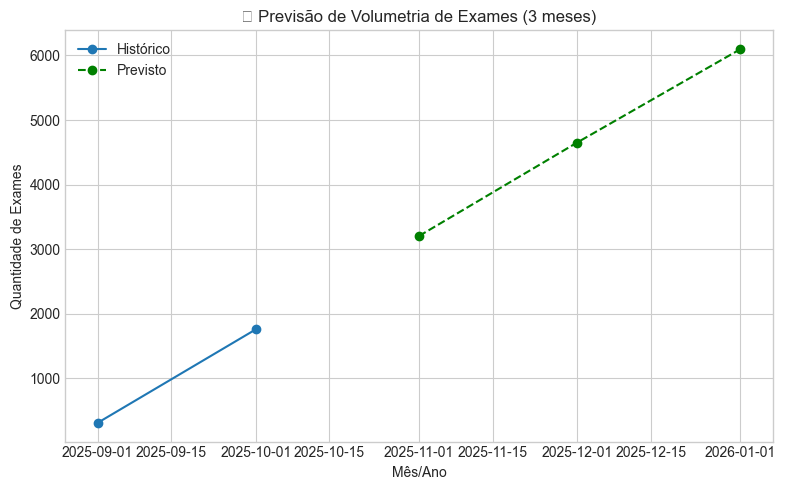

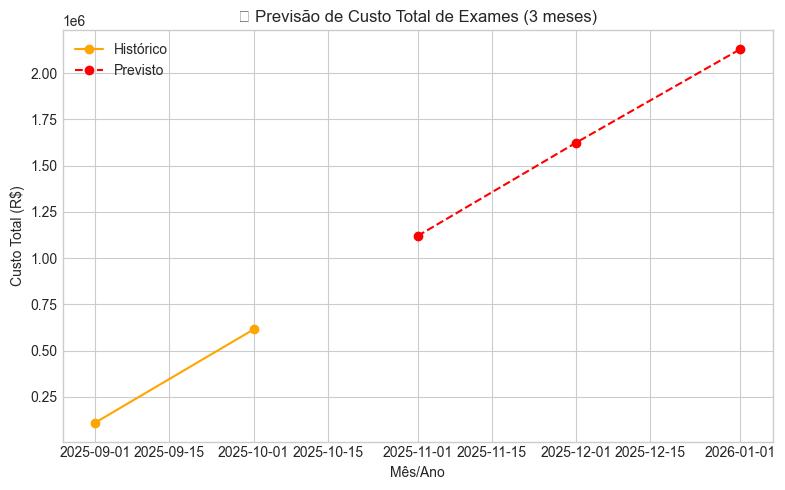

🔮 Previsões para os próximos 3 meses:
  mes_previsto  volume_previsto  custo_previsto_R$
0   2025-11-01             3204         1119515.02
1   2025-12-01             4651         1624877.66
2   2026-01-01             6098         2130240.30


In [13]:


# 1- Preparação dos dados
df3['data_inicio'] = pd.to_datetime(df3['data_inicio'])
df3['mes_ano'] = df3['data_inicio'].dt.to_period('M')

# Agrupamento mensal
df_monthly = df3.groupby('mes_ano').agg({
    'id_exame': 'count',
    'custo_material': 'sum',
    'custo_mao_obra': 'sum'
}).reset_index()

# Conversão para datetime
df_monthly['mes_ano'] = df_monthly['mes_ano'].astype(str)
df_monthly['mes_ano'] = pd.to_datetime(df_monthly['mes_ano'])

# Cálculo do custo total
df_monthly['custo_total'] = df_monthly['custo_material'] + df_monthly['custo_mao_obra']

# Cria variável numérica para regressão (índice temporal)
df_monthly['indice_tempo'] = np.arange(len(df_monthly))

# 2- Regressão linear - previsão de volumetria
modelo_volume = LinearRegression()
X = df_monthly[['indice_tempo']]
y_vol = df_monthly['id_exame']
modelo_volume.fit(X, y_vol)

# 3- Regressão linear - previsão de custo total
modelo_custo = LinearRegression()
y_custo = df_monthly['custo_total']
modelo_custo.fit(X, y_custo)

# 4- Geração de previsões para os próximos 3 meses
proximos_meses = np.arange(len(df_monthly), len(df_monthly) + 3).reshape(-1, 1)

previsao_volume = modelo_volume.predict(proximos_meses)
previsao_custo = modelo_custo.predict(proximos_meses)

# Criação de DataFrame com previsões
df_prev = pd.DataFrame({
    'mes_previsto': pd.date_range(
        start=df_monthly['mes_ano'].max() + pd.offsets.MonthBegin(),
        periods=3,
        freq='MS'
    ),
    'volume_previsto': previsao_volume.round(0).astype(int),
    'custo_previsto_R$': previsao_custo.round(2)
})

# 5- Visualizações
plt.style.use('seaborn-v0_8-whitegrid')

# --- Volume de exames (histórico + previsão)
plt.figure(figsize=(8,5))
plt.plot(df_monthly['mes_ano'], df_monthly['id_exame'], marker='o', label='Histórico')
plt.plot(df_prev['mes_previsto'], df_prev['volume_previsto'], marker='o', linestyle='--', color='green', label='Previsto')
plt.title('📈 Previsão de Volumetria de Exames (3 meses)')
plt.xlabel('Mês/Ano')
plt.ylabel('Quantidade de Exames')
plt.legend()
plt.tight_layout()
plt.show()

# --- Custo total (histórico + previsão)
plt.figure(figsize=(8,5))
plt.plot(df_monthly['mes_ano'], df_monthly['custo_total'], marker='o', label='Histórico', color='orange')
plt.plot(df_prev['mes_previsto'], df_prev['custo_previsto_R$'], marker='o', linestyle='--', color='red', label='Previsto')
plt.title('💰 Previsão de Custo Total de Exames (3 meses)')
plt.xlabel('Mês/Ano')
plt.ylabel('Custo Total (R$)')
plt.legend()
plt.tight_layout()
plt.show()

# 6- Exibir resultados numéricos
print("🔮 Previsões para os próximos 3 meses:")
print(df_prev)



### Conclusão


A análise realizada mostrou uma tendência consistente de aumento na volumetria de exames e nos custos operacionais, evidenciando que o laboratório opera em um cenário de crescimento contínuo. Esses resultados só foram possíveis graças ao uso estruturado das etapas de preparação dos dados, limpeza, agregação, construção de indicadores e processos centrais das metodologias de BI e do ciclo CRISP-DM, que garantem confiabilidade e interpretabilidade antes da aplicação de qualquer técnica analítica.

A aplicação de modelos preditivos, especialmente a regressão linear, demonstrou que os próximos meses devem seguir a mesma tendência de alta. Tal comportamento reforça a importância do uso de análises preditivas no planejamento estratégico, permitindo antecipar cenários, otimizar a alocação de recursos e apoiar decisões voltadas à eficiência operacional e financeira do laboratório, reforçando também a importância de métodos formais de análise para antecipar necessidades e apoiar decisões operacionais. Ao conectar técnicas de ETL, análise descritiva e modelagem preditiva, o trabalho evidencia como métodos bem aplicados permitem transformar dados brutos em informações estratégicas, fortalecendo o planejamento, a gestão de recursos e a eficiência dos processos laboratoriais. A organização do projeto usando metodologia ágil auxiliou a estabelecer o foco dos KPIs. 